In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [122]:
df = pd.read_csv("SBAnational.csv")

/tmp/ipykernel_25157/3536806131.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SBAnational.csv")


In [123]:
df['MIS_Status'] = df.apply(
    lambda row: 'P I F' if pd.isna(row['ChgOffDate']) else 'CHGOFF' 
    if pd.isna(row['MIS_Status']) else row['MIS_Status'],
    axis=1
)
df['MIS_Status'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})
df = df.drop(["LoanNr_ChkDgt", "Name", "ChgOffDate", "DisbursementDate", "BalanceGross", "ChgOffPrinGr", "SBA_Appv"], axis=1)
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y')

df['ApprovalDate'] = df['ApprovalDate'].apply(
    lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)

df['ApprovalFY'] = pd.to_numeric(df['ApprovalFY'], errors='coerce')
df['ApprovalFY'] = df['ApprovalFY'].astype('Int64')  # Int64 permet d'avoir des NaN

cols_to_convert = ['GrAppv', 'DisbursementGross']

for col in cols_to_convert:
    df[col] = df[col].astype(str)  # S'assure que c'est une string
    df[col] = df[col].str.replace('[\$,]', '', regex=True)  # Retire $ et ,
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertit en float

df['State'] = df['State'].fillna(df['BankState'])
recession_start = pd.Timestamp('2007-12-01')
recession_end = pd.Timestamp('2009-06-30')
df['Recession'] = ((df['ApprovalDate'] >= recession_start) & (df['ApprovalDate'] <= recession_end)).astype(int)
# df['NewExist'] = df['NewExist'].map({2: 1, 1: 0, 0: np.nan})
# df['UrbanRural'] = df['UrbanRural'].map({2: 1, 1: 0, 0: np.nan})
df['HasFranchise'] = (df['FranchiseCode'] >= 100).astype(int)
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)  # Garde seulement Y et N, sinon NaN
df = df[df['RevLineCr'].notnull()]
df['LowDoc'] = df['LowDoc'].apply(lambda x: x if x in ['Y', 'N'] else np.nan)  # Garde seulement Y et N, sinon NaN
df = df[df['LowDoc'].notnull()]
df["NAICS"] = df["NAICS"].astype(str).str[:2]
df['NAICS'] = df['NAICS'].replace('0', np.nan)
df = df[df['NAICS'].notnull()]
df = df[df['Bank'].notnull()]
df = df[df['State'].notnull()]
df = df.drop(['DisbursementGross','City','Zip','BankState','ApprovalDate','ApprovalFY','FranchiseCode'], axis=1)

In [124]:
X['State'].unique()

array(['IN', 'CT', 'FL', 'NC', 'IL', 'OK', 'AR', 'MN', 'CA', 'SC', 'TX',
       'LA', 'IA', 'MS', 'OH', 'VA', 'PA', 'KS', 'AK', 'UT', 'CO', 'ID',
       'MI', 'RI', 'MA', 'NV', 'MD', 'NY', 'NJ', 'NH', 'MO', 'AZ', 'ND',
       'ME', 'WI', 'MT', 'AL', 'WA', 'VT', 'OR', 'KY', 'NM', 'GA', 'NE',
       'WY', 'TN', 'WV', 'SD', 'DE', 'DC', 'HI'], dtype=object)

In [125]:
features_of_interest = [
    'State', 'Bank', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 
       'GrAppv', 'Recession', 'HasFranchise'
    ]




data = df

target_name = "MIS_Status"
X, y = (
    data[features_of_interest],
    data[target_name]
)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)

In [127]:
from catboost import CatBoostClassifier

cat_features = ['NAICS', 'Bank', 'State', 'RevLineCr', 'LowDoc']

# Initialisation du modèle avec AUC comme métrique
model = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.1, 
    depth=6, 
    cat_features=cat_features, 
    eval_metric="AUC",  # Utilisation de l'AUC
    verbose=100
)

# Entraînement
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Prédiction des probabilités pour calculer l'AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc_score:.4f}")


0:	test: 0.9022034	best: 0.9022034 (0)	total: 174ms	remaining: 1m 27s
100:	test: 0.9758425	best: 0.9758425 (100)	total: 17.2s	remaining: 1m 8s
200:	test: 0.9798300	best: 0.9798300 (200)	total: 34.1s	remaining: 50.7s
300:	test: 0.9814191	best: 0.9814191 (300)	total: 51.3s	remaining: 33.9s
400:	test: 0.9822350	best: 0.9822369 (399)	total: 1m 8s	remaining: 16.9s
499:	test: 0.9827398	best: 0.9827398 (499)	total: 1m 25s	remaining: 0us

bestTest = 0.9827398247
bestIteration = 499

AUC: 0.9827


In [128]:
from catboost import CatBoostClassifier

cat_features = ['NAICS', 'Bank', 'State', 'RevLineCr', 'LowDoc']

# Initialisation du modèle avec AUC comme métrique
model = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.1, 
    depth=6, 
    cat_features=cat_features, 
    eval_metric='Precision',  # Utilisation de l'AUC
    verbose=100
)

# Entraînement
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

precision = model.score(X_test, y_test)
print(f'Précision sur l\'ensemble de test : {precision:.4f}')

0:	learn: 0.9442760	test: 0.9446696	best: 0.9446696 (0)	total: 164ms	remaining: 1m 21s
100:	learn: 0.9566834	test: 0.9563334	best: 0.9563334 (100)	total: 16.4s	remaining: 1m 4s
200:	learn: 0.9620437	test: 0.9614662	best: 0.9614662 (200)	total: 32.6s	remaining: 48.5s
300:	learn: 0.9645826	test: 0.9642194	best: 0.9642194 (299)	total: 49s	remaining: 32.4s
400:	learn: 0.9659516	test: 0.9655474	best: 0.9655474 (400)	total: 1m 5s	remaining: 16.2s
499:	learn: 0.9671432	test: 0.9663558	best: 0.9663558 (499)	total: 1m 22s	remaining: 0us

bestTest = 0.9663557537
bestIteration = 499

Précision sur l'ensemble de test : 0.9538


In [129]:
import optuna
from sklearn.metrics import precision_score

# Fonction d'optimisation pour Optuna
def objective(trial):
    # Définir les hyperparamètres à optimiser
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1e2),
        'custom_metric': ['Precision'],
        'verbose': 0  # Désactive les logs pour éviter d'être noyé d'informations
    }
    
    # Créer et entraîner le modèle
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, cat_features=cat_features)
    
    # Faire une prédiction et calculer la précision
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    
    # Retourner la précision comme objectif à optimiser
    return precision

# Créer un objet study pour Optuna
study = optuna.create_study(direction='maximize')  # Optimiser pour maximiser la précision
study.optimize(objective, n_trials=50)  # Effectuer 50 essais pour explorer les hyperparamètres

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés : ", study.best_params)

# Afficher la meilleure précision
print("Meilleure précision : ", study.best_value)


[I 2025-02-13 15:43:09,302] A new study created in memory with name: no-name-ca60b757-0580-4fbc-a2aa-e3393039d4db
/tmp/ipykernel_25157/733049040.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1e2),
[I 2025-02-13 15:45:22,512] Trial 0 finished with value: 0.9691544198289098 and parameters: {'iterations': 692, 'learning_rate': 0.17939127162432986, 'depth': 7, 'l2_leaf_reg': 1.3125276058585578}. Best is trial 0 with value: 0.9691544198289098.
/tmp/ipykernel_25157/733049040.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 1e2),
[I 2025-02-13 15

Meilleurs hyperparamètres trouvés :  {'iterations': 731, 'learning_rate': 0.24359454533605354, 'depth': 8, 'l2_leaf_reg': 4.305157241416214}
Meilleure précision :  0.9701861307857025


Meilleurs hyperparamètres trouvés :  {'iterations': 731, 'learning_rate': 0.24359454533605354, 'depth': 8, 'l2_leaf_reg': 4.305157241416214}
Meilleure précision :  0.9701861307857025

0:	learn: 0.9388882	test: 0.9387623	best: 0.9387623 (0)	total: 257ms	remaining: 3m 7s
100:	learn: 0.9665239	test: 0.9659293	best: 0.9660359 (97)	total: 22.4s	remaining: 2m 19s
200:	learn: 0.9698695	test: 0.9678701	best: 0.9679443 (189)	total: 44.7s	remaining: 1m 57s
300:	learn: 0.9719449	test: 0.9687808	best: 0.9688331 (289)	total: 1m 6s	remaining: 1m 34s
400:	learn: 0.9734804	test: 0.9692198	best: 0.9693777 (390)	total: 1m 27s	remaining: 1m 12s
500:	learn: 0.9746362	test: 0.9694592	best: 0.9695681 (480)	total: 1m 48s	remaining: 50s
600:	learn: 0.9757304	test: 0.9700014	best: 0.9701603 (589)	total: 2m 10s	remaining: 28.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9701603162
bestIteration = 589

Shrink model to first 590 iterations.
Précision sur l'ensemble de test : 0.9571
F1-score macro : 0.9359
AUC : 0.9842


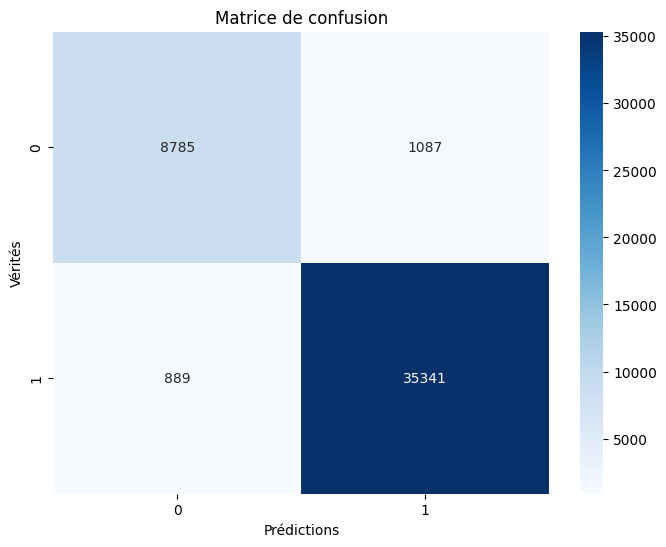

In [130]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

cat_features = ['NAICS', 'Bank', 'State', 'RevLineCr', 'LowDoc']

# Initialisation du modèle avec AUC comme métrique
model = CatBoostClassifier(
    iterations=731, 
    learning_rate=0.24359454533605354, 
    depth=8, 
    l2_leaf_reg = 4.305157241416214,
    cat_features=cat_features, 
    eval_metric='Precision',  # Utilisation de l'AUC
    verbose=100
)

# Entraînement
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Calculer la précision (score)
precision = model.score(X_test, y_test)
print(f'Précision sur l\'ensemble de test : {precision:.4f}')

# Faire des prédictions
y_pred = model.predict(X_test)

# Calculer le F1-score macro
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f'F1-score macro : {f1_macro:.4f}')

# Calculer l'AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Récupérer les probabilités de la classe positive (1)
auc = roc_auc_score(y_test, y_pred_prob)  # Calculer l'AUC
print(f'AUC : {auc:.4f}')

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()